<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Fifth_Working_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q

import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor


from time import time


from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv
from spektral import transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

PI = np.pi


# Lifehack
true = True
false = False

     |████████████████████████████████| 122kB 5.6MB/s 


In [ ]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

     |████████████████████████████████| 2.0MB 5.5MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 163kB 23.7MB/s 
     |████████████████████████████████| 133kB 16.2MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
################################################################################
# LOAD DATA
################################################################################
# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      e,a,z = g["y"]
      g["y"] = [transformer['energy_log10'].inverse_transform([[e]])[0][0],transformer['azimuth'].inverse_transform([[a]])[0][0],transformer['zenith'].inverse_transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])




#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


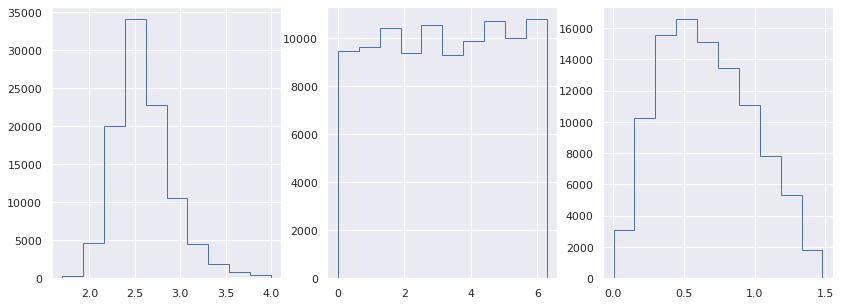

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

N = 100000

trs = np.empty((N,3))
for k in range(N):
  trs[k] = dataset[k]["y"]

for k in range(3):
  axs[k].hist(trs[:,k],histtype="step")

In [ ]:
# from spektral.transforms import GCNFilter

# t = time.time()
# dataset.apply(GCNFilter())
# print(f"Goddamn, this takes {t-time.time():.3} seconds!")

In [ ]:
def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy = tf.abs(target[:,0] - predictions[:,0])

    azi  = [tf.cos(target[:,1]) - predictions[:,1] , 
            tf.sin(target[:,1]) - predictions[:,2]]

    zeni = [tf.cos(target[:,2]) - predictions[:,3] , 
            tf.sin(target[:,2]) - predictions[:,4]]


    loss = 0
    loss += tf.reduce_mean(tf.square(energy))
    loss += tf.reduce_mean(tf.square(azi[0]))
    loss += tf.reduce_mean(tf.square(azi[1]))
    loss += tf.reduce_mean(tf.square(zeni[0]))
    loss += tf.reduce_mean(tf.square(zeni[1]))
    loss += 0.1
    return loss

loss_fn = custom_loss


def custom_acc(target,predictions):
    predictions = tf.cast(predictions,"float64")

    
    energy    = tf.abs(target[:,0] - predictions[:,0])

    aziguess = tf.atan2(predictions[:,2],predictions[:,1])
    azi = tf.minimum( tf.abs(target[:,1] - aziguess) , tf.abs(tf.abs(target[:,1] - aziguess) - 2*PI))

    zeniguess = tf.atan2(predictions[:,4],predictions[:,3])
    zeni = tf.minimum( tf.abs(target[:,2] - zeniguess) , tf.abs(tf.abs(target[:,2] - zeniguess) - 2*PI))
    

    return (energy,azi,zeni)

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs




In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  32#@param {type: "number"}

# one-variable network size changer
network_size =  64#@param {type: "number"}

learning_rate = 2e-4  #@param {type: "number"}

training_epochs = 35 #@param {type: "slider", min: 10, max: 200}


loss_function = "rasmus_loss"  #@param ['custom_loss',"rasmus_loss"]

config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dataset": "MuonGun"
      }

epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs



In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
# n_out = dataset.n_labels  # Dimension of the target
n_out = 5

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)





class model_class(Model):
  def __init__(self):
    super().__init__()
    
    # self.preprocess = transforms.layer_preprocess.LayerPreprocess(GCNConv)

    # self.inp = ECCConv(network_size//4)
    self.conv = GCNConv(network_size//4,activation="gelu")    
    self.conv1 = GCNConv(network_size//2,activation="gelu")
    self.conv2 = GCNConv(network_size,activation="gelu")

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.largedense= Dense(network_size)
    self.mediumdense= Dense(network_size//2)
    self.smalldense = Dense(network_size//4)

    self.out = Dense(n_out)
    # self.oneout = Dense(1)

  def call(self, inputs, training = False):

    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this for myself
    # x = self.inp([x,a,e])
    # a = self.preprocess(a)
    x = self.conv([x,a])
    x = self.conv1([x,a])
    x = self.conv2([x,a])

    
    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs], axis = 1) 


    # x = self.largedense(x)
    x = self.largedense(x)
    x = self.mediumdense(x)
    
    x = self.smalldense(x)
    out = self.out(x)

    # xe = self.smalldense(x)
    # xa = self.smalldense(x)
    # xz = self.smalldense(x)

    # oute = self.oneout(xe)
    # outa1 = self.oneout(xa)
    # outa2 = self.oneout(xa)

    # outz1 = self.oneout(xz)
    # outz2 = self.oneout(xz)


    return out
    # return tf.concat([oute, outa1,outa2, outz1,outz2], axis = 1) 


  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()


model.compile()
# model.build()
# fit(train_loader)

In [ ]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc




loss_fn = custom_loss
acc_fn = custom_acc
def fit(train_loader,logwandb = False):
  if logwandb:
    run = wandb.init(project='IceCube GNN Bachelor',config = config)

  current_batch = 0
  model_loss = []
  model_acc = []
  vali_loss = []
  epoch = 0

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True, ncols='70%')
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  
  for batch in train_loader:
      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)

      if step%10 == 0:
        t.set_description(f'Current loss {np.mean(model_loss):.3} | Working on epoch {epoch} of {epochs}:')

      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results for epoch {epoch} of {epochs}:')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            valoss, vaacc = validate(vali_inputs,vali_target)
            vali_loss.append(valoss)
          va = np.mean(vali_loss)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Loss change {:+.3f}% | Validation loss {} | Epoch: {}".format(m_loss, change*100,va, epoch)
          t.write(s)

          ma = np.array(model_acc)
          s = "Accuracy is: Energy {} | Azimuth {} | Zenith {}\n".format(np.mean(ma[:,0]),np.mean(ma[:,1]),np.mean(ma[:,2]))
          t.write(s)
          # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])

          # if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
            # pass
          # else:
            # pb = model(inputs, training=False)
            # tar = target



          if logwandb:
            wandb.log({
                      "train_loss": m_loss,
                      "energy_accuracy": np.mean(ma[:,0]),
                      "azimuth_accuracy": np.mean(ma[:,1]),
                      "zenith_accuracy": np.mean(ma[:,2]),
                      "val_loss": va,
                      })




          model_loss = []
          model_acc = []
          vali_loss = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()
          epoch += 1



In [107]:
logwandb = True

fit(train_loader,logwandb = logwandb)

print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"


if logwandb:
  pth = save_path + f"/{wandb.run.name}-{int(epochs)}epochs"
  wandb.run.finish()  
else:
  pth = save_path + "ThomasVersionGoodDataProductionNoEdge"

model.save(pth)

Train loss: 781.5302248906797 - Loss change +78153022489.068% | Validation loss 15.636469726459053 | Epoch: 0
Accuracy is: Energy 2.7077061457337632 | Azimuth 3.7958518177250538 | Zenith 1.1373273951844924

Train loss: 108.55373132384118 - Loss change -86.110% | Validation loss 11.39227155339416 | Epoch: 1
Accuracy is: Energy 1.1873687643540964 | Azimuth 3.663930936620146 | Zenith 0.835112083592997

Train loss: 14.503662993726476 - Loss change -86.639% | Validation loss 1.7485000346506487 | Epoch: 2
Accuracy is: Energy 0.5005592845257132 | Azimuth 3.5335603042789345 | Zenith 0.47328564854385996

Train loss: 2.898406950329387 - Loss change -80.016% | Validation loss 1.3525020165709893 | Epoch: 3
Accuracy is: Energy 0.3076193757961282 | Azimuth 3.487967276306762 | Zenith 0.32917258964687857

Train loss: 1.759099858604091 - Loss change -39.308% | Validation loss 1.2705761069240873 | Epoch: 4
Accuracy is: Energy 0.21999828759054266 | Azimuth 3.414933473035784 | Zenith 0.28087323427260286



train_loss,0.87363
energy_accuracy,0.17476
azimuth_accuracy,3.41418
zenith_accuracy,0.20264
val_loss,0.88053
_runtime,4251
_timestamp,1614177230
_step,34


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
energy_accuracy,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
azimuth_accuracy,█▆▃▂▁▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
zenith_accuracy,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/fancy-silence-64-35epochs/assets


In [134]:

# keras.models.load_model("/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/astral-valley-61-52epochs")

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  return model(inputs,training = False)

def get_true_guesses(inputs,target):
  pred = model(inputs,training = False)
  energy = pred[:,0]
  azi  = tf.atan2(pred[:,2],pred[:,1])
  zeni = tf.atan2(pred[:,4],pred[:,3])
  return (energy,azi,zeni)


def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

def test_model():
  print("Testing model")
  model_loss, model_acc = [],[]

  test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=10,shuffle = True)

  predictions, truths = [],[]

  for batch in tqdm(test_loader):
    inputs, target = batch
    inputs = scale_inputs(inputs) 
    # print(inputs)
    pred = get_predictions(inputs,target)

    true_guesses = get_true_guesses(inputs,target)

    predictions.append(true_guesses)
    truths.append(np.array(target))
    
    # print(pred)
    model_loss.append(loss_fn(target, np.array(pred)))
    model_acc.append(acc_fn(target, pred))
  
  model_acc = np.array(model_acc)
  print(f"Done! \nModel loss {np.mean(model_loss)} | Energy accuracy {np.mean(model_acc[:,0])} | Azimuth accuracy {np.mean(model_acc[:,1])} | Zenith accuracy {np.mean(model_acc[:,2])}")
  return predictions, truths


def make_plots(predictions, truths):
  preds, trs = [],[]

  for p,t in zip(predictions,truths):
    preds.append(np.array(p))
    trs.append([t[:,0],t[:,1],t[:,2]])

  trs = np.array(trs)
  preds = np.array(preds)


  fig, axs = plt.subplots(1,3,figsize=(17,7))

  titles = ["Energy","Azimuth","Zenith"]
  for k in range(3):
    add = 0
    if k == 1:
      add = PI
    axs[k].hist(trs[:,k].flatten(),bins=100,histtype="step")
    axs[k].hist(preds[:,k].flatten()+add,bins=100,histtype="step")
    axs[k].set_title(titles[k])
  plt.show()
  

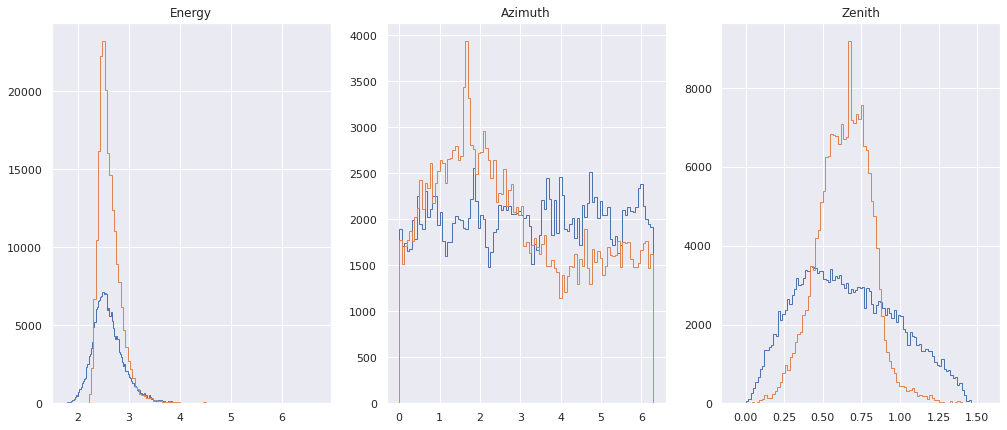

In [135]:
# predictions, truths = test_model()

make_plots(predictions, truths)

In [121]:
e,a,z = predictions[0]
et,at,zt = truths[0][:,0],truths[0][:,1],truths[0][:,2]

